In [22]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import joblib
import json

In [3]:
df_raw = pd.read_csv("crop_yield.csv")
print('✅ Loaded dataset. Shape:', df_raw.shape)
df_raw.head()

✅ Loaded dataset. Shape: (1000000, 10)


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [4]:
# Standardize column names: lowercase + underscores
df = df_raw.copy()
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print('Columns:', list(df.columns))
print('\nBasic info:')
print(df.info())
print('\nSample rows:')
display(df.head(10))

Columns: ['region', 'soil_type', 'crop', 'rainfall_mm', 'temperature_celsius', 'fertilizer_used', 'irrigation_used', 'weather_condition', 'days_to_harvest', 'yield_tons_per_hectare']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   region                  1000000 non-null  object 
 1   soil_type               1000000 non-null  object 
 2   crop                    1000000 non-null  object 
 3   rainfall_mm             1000000 non-null  float64
 4   temperature_celsius     1000000 non-null  float64
 5   fertilizer_used         1000000 non-null  bool   
 6   irrigation_used         1000000 non-null  bool   
 7   weather_condition       1000000 non-null  object 
 8   days_to_harvest         1000000 non-null  int64  
 9   yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int

,region,soil_type,crop,rainfall_mm,temperature_celsius,fertilizer_used,irrigation_used,weather_condition,days_to_harvest,yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
5,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416
6,West,Clay,Wheat,357.902357,31.593431,False,False,Rainy,90,2.652392
7,South,Sandy,Rice,441.131154,30.887107,True,True,Sunny,61,5.829542
8,North,Silt,Wheat,181.587861,26.752729,True,False,Sunny,127,2.943716
9,West,Sandy,Wheat,395.048968,17.646199,False,True,Rainy,140,3.707293


In [5]:
# Attempt to identify the likely production and area columns by common names

possible_prod = [c for c in df.columns if any(x in c.lower() for x in ['prod', 'output', 'ton'])]
possible_area = [c for c in df.columns if any(x in c.lower() for x in ['area', 'hect'])]

target_col = None

if 'yield' in df.columns:
    target_col = 'yield'
    print('ℹ️ Using existing target column: yield')
else:
    # Choose first matching columns for production and area if available
    prod_col = possible_prod[0] if possible_prod else None
    area_col = possible_area[0] if possible_area else None

    if prod_col and area_col:
        # Avoid division by zero
        safe_area = df[area_col].replace(0, np.nan)
        df['yield'] = df[prod_col] / safe_area
        target_col = 'yield'
        print(f'ℹ️ Derived target yield = {prod_col} / {area_col}')
    else:
        raise ValueError('Could not find columns to derive `yield`. Please ensure columns for Production and Area exist, or add a `yield` column.')

# Report missing in target
missing_target = df['yield'].isna().sum()
print(f'Missing in target (yield): {missing_target}')
# Drop rows without target
df = df.dropna(subset=['yield']).copy()

# Basic sanity filter: drop infs or absurd values if any
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['yield'])
print('✅ Target ready. Remaining shape:', df.shape)
df[['yield']].describe()

ℹ️ Derived target yield = yield_tons_per_hectare / yield_tons_per_hectare
Missing in target (yield): 0
✅ Target ready. Remaining shape: (1000000, 11)


,yield
count,1000000.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [6]:
# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print('Missing values per column:')
display(missing[missing > 0])

# Descriptive statistics of numeric columns
display(df.describe(include=[np.number]).T)

Missing values per column:


Series([], dtype: int64)

,count,mean,std,min,25%,50%,75%,max
rainfall_mm,1000000.0,549.981901,259.851320,100.000896,324.891090,550.124061,774.738520,999.998098
temperature_celsius,1000000.0,27.504965,7.220608,15.000034,21.254502,27.507365,33.753267,39.999997
days_to_harvest,1000000.0,104.495025,25.953412,60.000000,82.000000,104.000000,127.000000,149.000000
yield_tons_per_hectare,1000000.0,4.649472,1.696572,-1.147613,3.417637,4.651808,5.879200,9.963372
yield,1000000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


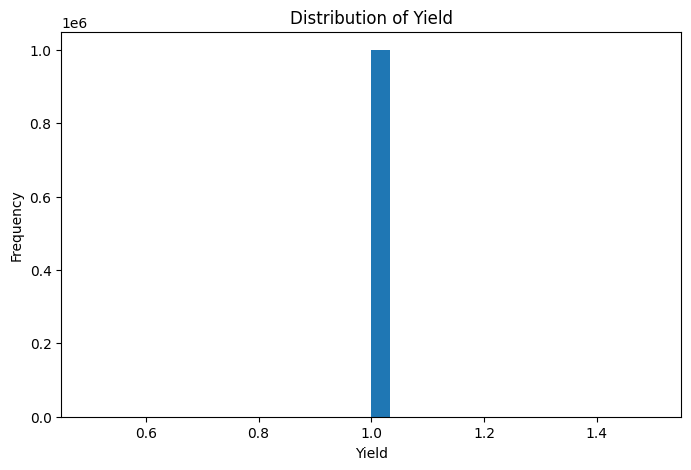

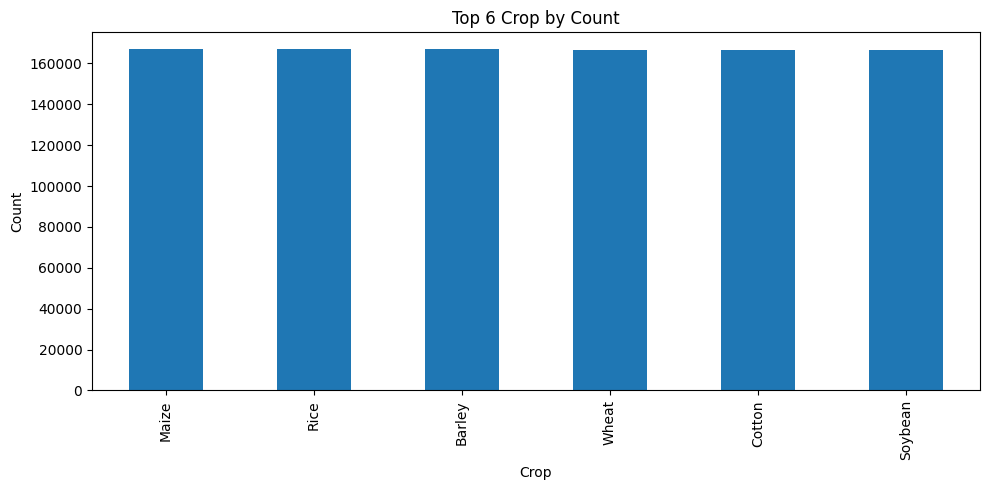

In [7]:
# Histogram of target
plt.figure(figsize=(8,5))
plt.hist(df['yield'].dropna(), bins=30)
plt.title('Distribution of Yield')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()

# If there is a 'crop' or similar categorical column, show top counts
cat_candidates = ['crop', 'crop_name']
showed = False
for c in cat_candidates:
    if c in df.columns:
        top_counts = df[c].value_counts().head(10)
        plt.figure(figsize=(10,5))
        top_counts.plot(kind='bar')
        plt.title(f'Top {len(top_counts)} {c.title()} by Count')
        plt.xlabel(c.title())
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        showed = True
        break

if not showed:
    print('ℹ️ No obvious crop column found for bar chart. Skipping.')

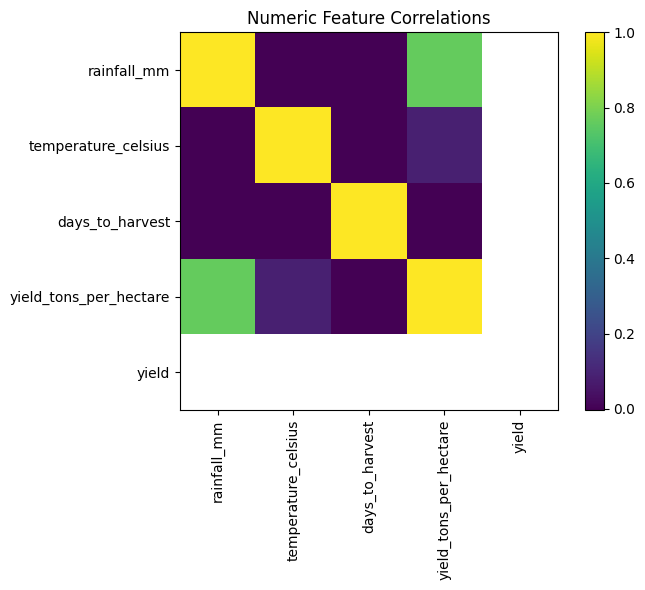

In [8]:
# Correlation matrix for numeric features (excluding any purely categorical)
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 2:
    corr = numeric_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Numeric Feature Correlations')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()
else:
    print('ℹ️ Not enough numeric columns to compute correlation heatmap.')

In [9]:
# Define features (X) and target (y)
y = df['yield'].astype(float)
X = df.drop(columns=['yield']).copy()

# Identify categorical vs numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print('Categorical columns:', categorical_cols)
print('Numeric columns:', numeric_cols)


Categorical columns: ['region', 'soil_type', 'crop', 'weather_condition']
Numeric columns: ['rainfall_mm', 'temperature_celsius', 'days_to_harvest', 'yield_tons_per_hectare']


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('Train shape:', X_train.shape, 'Valid shape:', X_valid.shape)

Train shape: (800000, 10) Valid shape: (200000, 10)


In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

print('✅ Preprocessor ready.')

✅ Preprocessor ready.


In [12]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Create pipelines (preprocessing + model)
pipelines = {name: Pipeline(steps=[('pre', preprocessor), ('model', mdl)])
             for name, mdl in models.items()}

print('✅ Model pipelines defined:', list(pipelines.keys()))

✅ Model pipelines defined: ['LinearRegression', 'Ridge', 'RandomForest', 'GradientBoosting']


In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

cv_results = {}

for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results[name] = {
        'MAE_mean': -scores['test_MAE'].mean(),
        'MAE_std':  scores['test_MAE'].std(),
        'RMSE_mean': -scores['test_RMSE'].mean(),
        'RMSE_std':  scores['test_RMSE'].std(),
        'R2_mean':  scores['test_R2'].mean(),
        'R2_std':   scores['test_R2'].std(),
    }

cv_df = pd.DataFrame(cv_results).T.sort_values('RMSE_mean')
print('Cross‑validation results (lower MAE/RMSE is better, higher R2 is better):')
display(cv_df)

Cross‑validation results (lower MAE/RMSE is better, higher R2 is better):


,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
LinearRegression,-0.0,0.0,-0.0,0.0,1.0,0.0
Ridge,-0.0,0.0,-0.0,0.0,1.0,0.0
RandomForest,-0.0,0.0,-0.0,0.0,1.0,0.0
GradientBoosting,-0.0,0.0,-0.0,0.0,1.0,0.0


In [15]:
best_name = cv_df.index[0]
best_pipe = pipelines[best_name]
best_pipe.fit(X_train, y_train)

# Validation performance
preds = best_pipe.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
rmse = np.sqrt(mean_squared_error(y_valid, preds))  # fixed line
r2 = r2_score(y_valid, preds)

print(f'🏆 Best model by CV: {best_name}')
print(f'Validation MAE:  {mae:.4f}')
print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation R²:   {r2:.4f}')


🏆 Best model by CV: LinearRegression
Validation MAE:  0.0000
Validation RMSE: 0.0000
Validation R²:   1.0000


In [18]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

best_model_path = MODEL_DIR / 'best_model.joblib'
joblib.dump(best_pipe, best_model_path)
print('✅ Saved best pipeline to:', best_model_path)


✅ Saved best pipeline to: models/best_model.joblib


In [19]:
# Build a single example row by taking medians/modes from training data
example = {}
for c in numeric_cols:
    example[c] = X_train[c].median() if c in X_train.columns else np.nan
for c in categorical_cols:
    example[c] = X_train[c].mode().iloc[0] if c in X_train.columns and not X_train[c].mode().empty else ''

example_df = pd.DataFrame([example])
print('Example input row:')
display(example_df)

pred_yield = best_pipe.predict(example_df)[0]
print(f'🧪 Predicted Yield for example row: {pred_yield:.4f}')

Example input row:


,rainfall_mm,temperature_celsius,days_to_harvest,yield_tons_per_hectare,region,soil_type,crop,weather_condition
0,549.992266,27.517912,104.0,4.65,North,Sandy,Wheat,Sunny


🧪 Predicted Yield for example row: 1.0000


In [20]:
# Attempt to extract feature importances if the final estimator supports it
final_est = best_pipe.named_steps['model']
if hasattr(final_est, 'feature_importances_'):
    # Recreate the transformed feature names
    ohe = best_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['encoder']
    cat_feats = ohe.get_feature_names_out(categorical_cols)
    all_feats = np.concatenate([np.array(numeric_cols), cat_feats])
    importances = final_est.feature_importances_
    # Sort and plot top 20
    idx = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(10,6))
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), all_feats[idx], rotation=90)
    plt.title('Top 20 Feature Importances (if available)')
    plt.tight_layout()
    plt.show()
else:
    print('ℹ️ Chosen best model does not expose feature_importances_. Skipping plot.')

ℹ️ Chosen best model does not expose feature_importances_. Skipping plot.


In [23]:
metrics = {
    'best_model': best_name,
    'validation': {'MAE': float(mae), 'RMSE': float(rmse), 'R2': float(r2)},
    'cv': cv_df.to_dict(orient='index')
}
metrics_path = MODEL_DIR / 'model_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print('✅ Saved metrics to:', metrics_path)

✅ Saved metrics to: models/model_metrics.json
